In [137]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Add, GlobalAveragePooling2D, ZeroPadding2D, Dense, Input, Concatenate, Multiply, Dropout, Reshape, UpSampling2D, DepthwiseConv2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [138]:
# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Print the shape of the dataset
print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


In [139]:
# Finding the number of labels and their counts in the training set

# Map labels to their corresponding clothing item names
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get the unique labels and their counts
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Create a dictionary of label counts
label_counts = dict(zip(label_names, counts))

# Display the label types and their counts
print("Label types:", label_names)
print("Label counts:", label_counts)

Label types: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Label counts: {'T-shirt/top': 6000, 'Trouser': 6000, 'Pullover': 6000, 'Dress': 6000, 'Coat': 6000, 'Sandal': 6000, 'Shirt': 6000, 'Sneaker': 6000, 'Bag': 6000, 'Ankle boot': 6000}


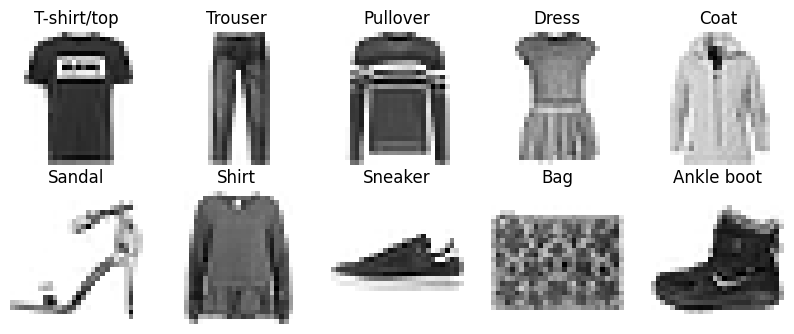

In [140]:
# Find a representative image for each label

representatives = {}
for label in unique_labels:
    index = np.where(train_labels == label)[0][0]
    representatives[label] = train_images[index]

# Plot the representative images
plt.figure(figsize=(10, 10))
for i, (label, image) in enumerate(representatives.items()):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image, cmap='binary')
    plt.title(label_names[label])
    plt.axis('off')

plt.show()

In [141]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape the training and test images to include the channel dimension
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [228]:
random.seed(21)
np.random.seed(21)
tf.random.set_seed(21)

def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        # Dense layer
        x1 = BatchNormalization()(x)
        x1 = ReLU()(x1)
        x1 = Conv2D(growth_rate, (3, 3), padding='same', kernel_regularizer = l2(1e-4))(x1)
        x = Concatenate(axis=-1)([x, x1])
    return x

def transition_layer(x, reduction):
    filters = int(x.shape[-1] * reduction)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (1, 1), padding='same', kernel_regularizer = l2(1e-4))(x)

    # Ensure dimensions are large enough for pooling
    if x.shape[1] <= 1 or x.shape[2] <= 1:
        x = ZeroPadding2D(padding=(1, 1))(x)
        
    x = MaxPooling2D((2, 2))(x)
        
    return x

def attention_residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer= l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(filters, kernel_size, strides=1, padding='same', activation=None, kernel_regularizer = l2(1e-4))(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', activation=None, kernel_regularizer = l2(1e-4))(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Attention mechanism
    attention = Conv2D(filters, (1, 1), activation='sigmoid')(x)
    x = Multiply()([x, attention])
    
    # Add shortcut to the output (skip connection)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

def squeeze_excite_block(x, filters):
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // 16, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    
    # Reshape `se` to match the shape of `x` for multiplication
    se = Reshape((1, 1, filters))(se)  # Shape: (batch_size, 1, 1, filters)
    
    se = Multiply()([x, se])
    return se

def inception_block(x, filters):
    branch1x1 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    branch5x5 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters, (5, 5), padding='same', activation='relu')(branch5x5)

    branch3x3 = Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters, (3, 3), padding='same', activation='relu')(branch3x3)

    branch_pool = MaxPooling2D((1, 1), strides=1, padding='same')(x)
    branch_pool = Conv2D(filters, (1, 1), padding='same', activation='relu')(branch_pool)

    outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
    return outputs

def build_model():
    input_tensor = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), padding='same', kernel_regularizer = l2(1e-4))(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2))(x)

    x = attention_residual_block(x, filters=64)
    x = MaxPooling2D((2, 2))(x)

    x = attention_residual_block(x, filters=128)
    x = MaxPooling2D((2, 2))(x)

    x = attention_residual_block(x, filters=256)
    x = MaxPooling2D((2, 2))(x)
    
 


    
    x = dense_block(x, num_layers=2, growth_rate=32)
    x = transition_layer(x, reduction=0.5)

    x = dense_block(x, num_layers=2, growth_rate=64)
    x = transition_layer(x, reduction=0.5)

    x = dense_block(x, num_layers=2, growth_rate=128)
    x = transition_layer(x, reduction=0.5)

    x = dense_block(x, num_layers=2, growth_rate=256)


    if x.shape[1] <= 1 or x.shape[2] <= 1:
        x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((2, 2))(x)  # Add pooling only if dimensions are sufficient

 

    x = inception_block(x, filters=512)
    x = squeeze_excite_block(x, filters=x.shape[-1])


    x = GlobalAveragePooling2D()(x)

    x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)

    output_tensor = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [229]:
# Build and compile the model
model = build_model()
#the complete architecture of our model.
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1115 (Conv2D)           (None, 28, 28, 32)   320         ['input_36[0][0]']               
                                                                                                  
 batch_normalization_800 (Batch  (None, 28, 28, 32)  128         ['conv2d_1115[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu_696 (ReLU)               (None, 28, 28, 32)   0           ['batch_normalization_800[

In [230]:
#Copile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5.12e-4)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [231]:
# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7, verbose=2)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=28, restore_best_weights=True, verbose=2)

In [232]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [233]:
# Fit the model with data augmentation
batch_size = 128
epochs = 128

# Train the model
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    validation_data=(test_images, test_labels),
                    epochs=epochs,
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/128
469/469 [==============================] - 37s 69ms/step - loss: 1.3556 - accuracy: 0.7056 - val_loss: 1.1168 - val_accuracy: 0.7556 - lr: 5.1200e-04
Epoch 2/128
469/469 [==============================] - 33s 70ms/step - loss: 0.9011 - accuracy: 0.8208 - val_loss: 0.8312 - val_accuracy: 0.8349 - lr: 5.1200e-04
Epoch 3/128
469/469 [==============================] - 34s 72ms/step - loss: 0.7772 - accuracy: 0.8448 - val_loss: 0.8381 - val_accuracy: 0.8029 - lr: 5.1200e-04
Epoch 4/128
469/469 [==============================] - 34s 72ms/step - loss: 0.6958 - accuracy: 0.8574 - val_loss: 0.6404 - val_accuracy: 0.8739 - lr: 5.1200e-04
Epoch 5/128
469/469 [==============================] - 34s 72ms/step - loss: 0.6387 - accuracy: 0.8668 - val_loss: 0.5827 - val_accuracy: 0.8816 - lr: 5.1200e-04
Epoch 6/128
469/469 [==============================] - 34s 71ms/step - loss: 0.5908 - accuracy: 0.8741 - val_loss: 0.6200 - val_accuracy: 0.8628 - lr: 5.1200e-04
Epoch 7/128
469/469 [=======

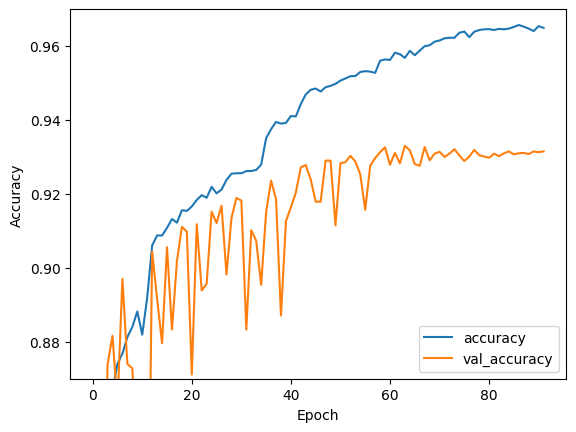

In [234]:
#Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.87, 0.97])
plt.legend(loc='lower right')
plt.show()


In [235]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 6s - loss: 0.2833 - accuracy: 0.9330 - 6s/epoch - 18ms/step


In [214]:
# Predict labels for test dataset
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

313/313 [==============================] - 3s 8ms/step


In [215]:
# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

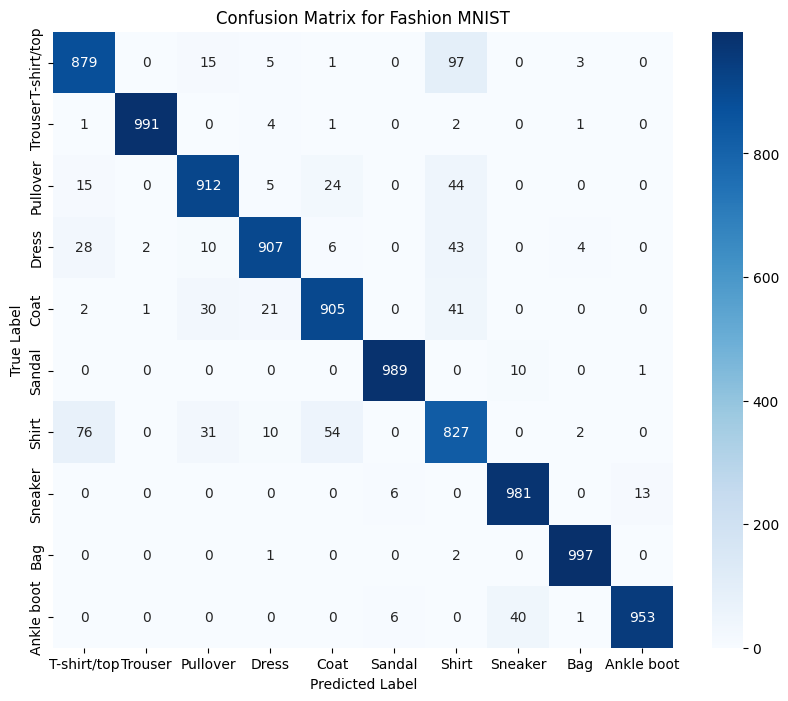

In [216]:
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Fashion MNIST")
plt.show()

In [56]:
print(f"Accuracy of the model is: {test_acc:.2f}")

Accuracy of the model is: 0.94
